HAM Training samples: 8012, Validation samples: 1001, Test samples: 1002
Epoch [1/40] -> Train Loss: 0.7977, Train Acc: 0.7141, Val Loss: 0.6565, Val Acc: 0.7722
New best model!
Epoch [2/40] -> Train Loss: 0.5450, Train Acc: 0.8037, Val Loss: 0.4985, Val Acc: 0.8342
New best model!
Epoch [3/40] -> Train Loss: 0.4461, Train Acc: 0.8396, Val Loss: 0.4113, Val Acc: 0.8621
New best model!
Epoch [4/40] -> Train Loss: 0.3799, Train Acc: 0.8598, Val Loss: 0.4209, Val Acc: 0.8571
Epoch [5/40] -> Train Loss: 0.3385, Train Acc: 0.8794, Val Loss: 0.3625, Val Acc: 0.8741
New best model!
Epoch [6/40] -> Train Loss: 0.2805, Train Acc: 0.9024, Val Loss: 0.3585, Val Acc: 0.8781
New best model!
Epoch [7/40] -> Train Loss: 0.2450, Train Acc: 0.9104, Val Loss: 0.3664, Val Acc: 0.8701
Epoch [8/40] -> Train Loss: 0.2325, Train Acc: 0.9196, Val Loss: 0.3640, Val Acc: 0.8811
New best model!
Epoch [9/40] -> Train Loss: 0.1922, Train Acc: 0.9289, Val Loss: 0.3406, Val Acc: 0.8951
New best model!
Epoch [10/40] 

<ipython-input-2-72a26fa4884b>:304: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))



**Classification Report on HAM Test Set:**
              precision    recall  f1-score   support

       akiec       0.74      0.78      0.76        32
         bcc       0.84      0.79      0.81        52
         bkl       0.84      0.80      0.82       110
          df       0.89      0.73      0.80        11
         mel       0.71      0.75      0.73       112
          nv       0.95      0.95      0.95       671
        vasc       0.81      0.93      0.87        14

    accuracy                           0.90      1002
   macro avg       0.83      0.82      0.82      1002
weighted avg       0.90      0.90      0.90      1002



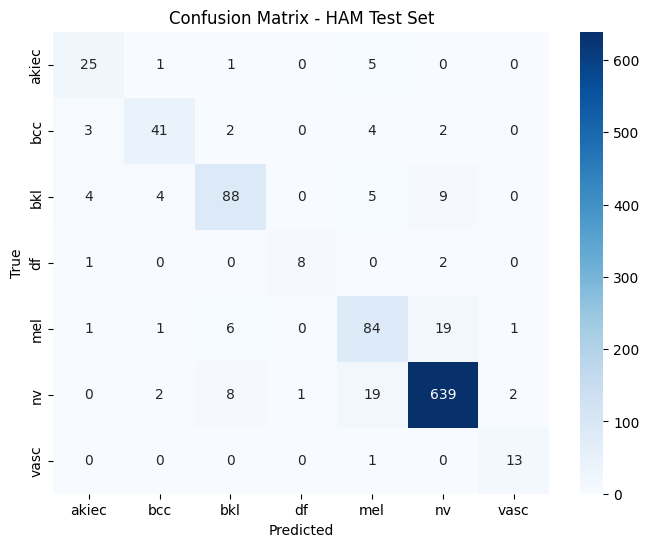

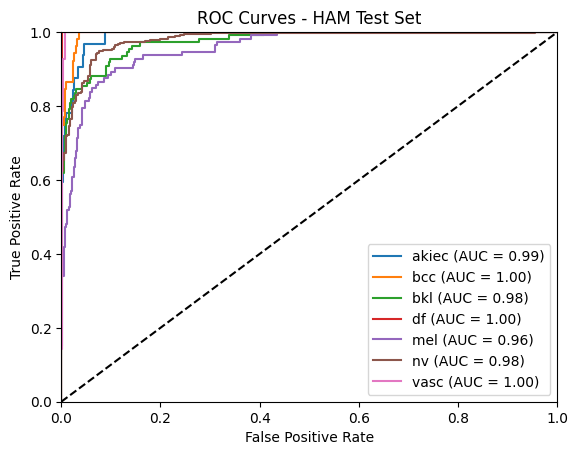


**Classification Report on ISIC Test Set:**
              precision    recall  f1-score   support

       akiec       0.49      0.56      0.52        43
         bcc       0.83      0.58      0.68        93
         bkl       0.73      0.68      0.70       217
          df       0.89      0.57      0.69        44
         mel       0.59      0.64      0.61       171
          nv       0.89      0.94      0.92       908
        vasc       0.84      0.77      0.81        35

    accuracy                           0.82      1511
   macro avg       0.75      0.68      0.71      1511
weighted avg       0.82      0.82      0.82      1511



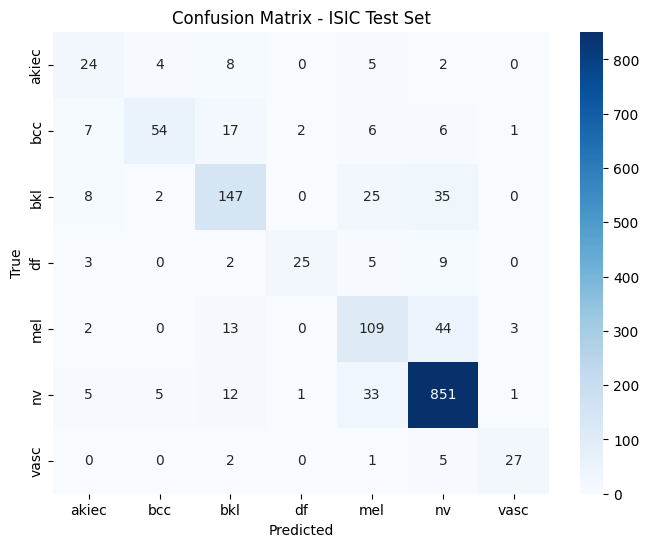

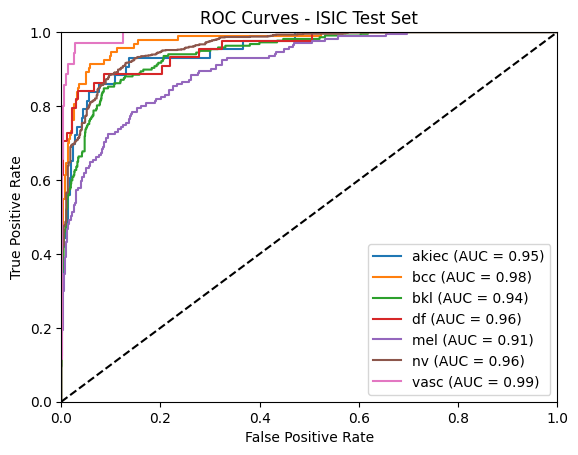

Training SVM classifier...
Evaluating SVM on HAM test set:

**Classification Report:**
              precision    recall  f1-score   support

       akiec       0.88      0.69      0.77        32
         bcc       0.87      0.87      0.87        52
         bkl       0.86      0.82      0.84       110
          df       0.83      0.91      0.87        11
         mel       0.72      0.71      0.72       112
          nv       0.95      0.97      0.96       671
        vasc       0.92      0.86      0.89        14

    accuracy                           0.91      1002
   macro avg       0.86      0.83      0.84      1002
weighted avg       0.91      0.91      0.91      1002



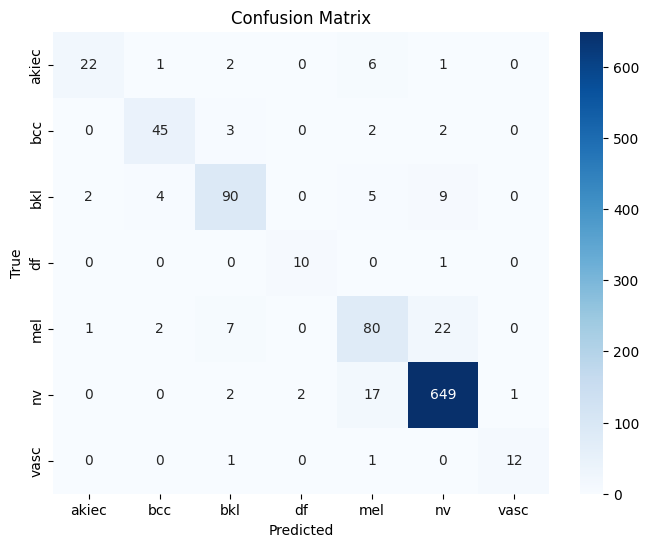

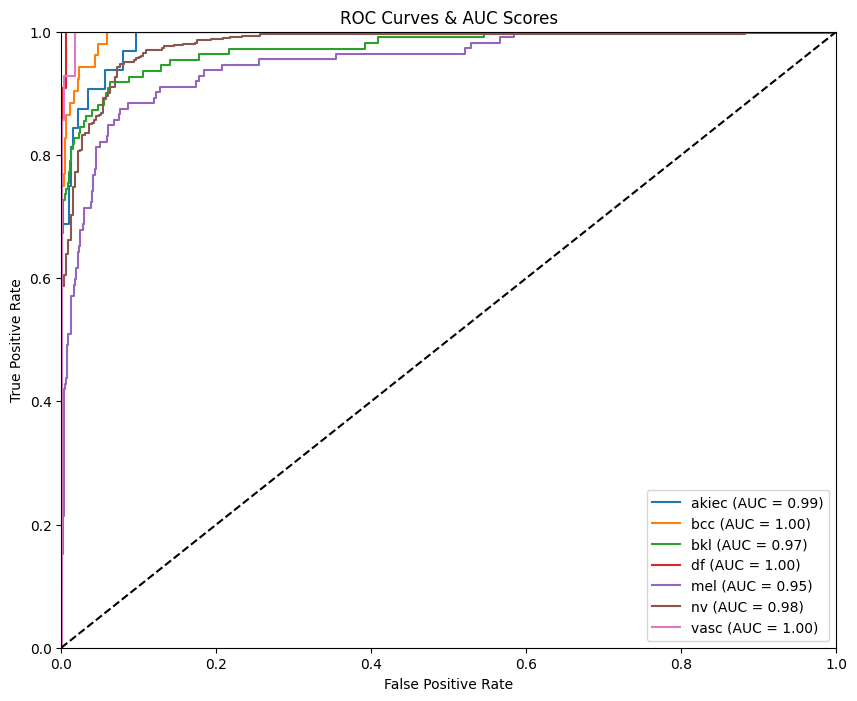

Evaluating SVM on ISIC test set:

**Classification Report:**
              precision    recall  f1-score   support

       akiec       0.57      0.63      0.60        43
         bcc       0.87      0.70      0.77        93
         bkl       0.77      0.70      0.73       217
          df       0.93      0.59      0.72        44
         mel       0.59      0.63      0.61       171
          nv       0.89      0.94      0.91       908
        vasc       0.91      0.60      0.72        35

    accuracy                           0.83      1511
   macro avg       0.79      0.68      0.73      1511
weighted avg       0.83      0.83      0.83      1511



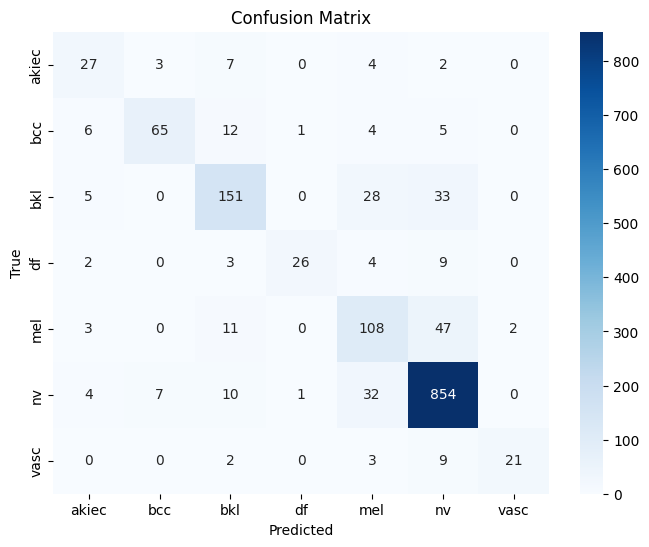

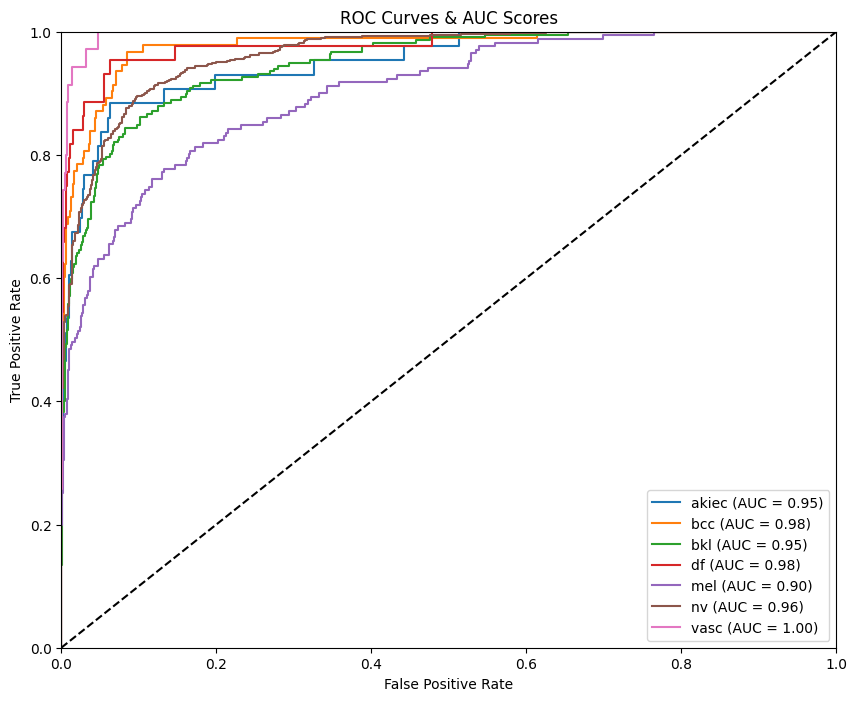

In [2]:
import torch
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import torch.nn as nn
from torch.utils.data import DataLoader

import seaborn as sns
from PIL import Image
from torch.utils.data import Dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.preprocessing import label_binarize
import torch.nn.functional as F

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score
import timm

# ---------------------------
# Hyperparameters
# ---------------------------
NUM_EPOCHS = 40
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
DROPOUT_P = 0.3
PATIENCE = 5
TARGET_SAMPLES_PER_CLASS = 2000 

# ---------------------------
# Define Paths
# ---------------------------
BASE_PATH = "/kaggle/input/ham10000"
    
# HAM10000 paths
HAM_IMAGES_FOLDER = os.path.join(BASE_PATH, "HAM10000", "HAM10000_images")
HAM_METADATA_FILE = os.path.join(BASE_PATH, "HAM10000", "HAM10000_metadata")  # Ensure CSV

# ISIC2018 paths
ISIC_IMAGES_FOLDER = os.path.join(BASE_PATH, "ISIC2018_images", "ISIC2018_images")
ISIC_METADATA_FILE = os.path.join(BASE_PATH, "ISIC2018_images", "ISIC2018_metadata")  # Ensure CSV

CHECKPOINT_PATH = "best_fusion_model.pth"

# ---------------------------
# Augmentation Strategy
# ---------------------------
train_transform = A.Compose([
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.RandomRotate90(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=180, p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.HueSaturationValue(p=0.2),
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# -----------
# Model
# -----------

class FusionModelTimm(nn.Module):
    def __init__(self, num_classes=7):
        super(FusionModelTimm, self).__init__()
        # ---------------------------
        # EfficientNet-b3 Branch (via timm)
        # ---------------------------
        self.efficientnet = timm.create_model('efficientnet_b3', pretrained=True, num_classes=0)
        # Expected feature dimension: 1536
        
        # ---------------------------
        # ResNet50 Branch (via timm)
        # ---------------------------
        self.resnet50 = timm.create_model('resnet50', pretrained=True, num_classes=0)
        # Expected feature dimension: 2048
        
        # ---------------------------
        # ViT Branch (via timm)
        # ---------------------------
        # Using ViT-Base with patch size 16 (feature dimension typically 768)
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=0)
        
        # ---------------------------
        # Fusion Classifier
        # ---------------------------
        # Total concatenated features: 1536 + 2048 + 768 = 4352
        fusion_in_features = 4352
        self.classifier = nn.Sequential(
            nn.Linear(fusion_in_features, 512),
            nn.ReLU(),
            nn.Dropout(DROPOUT_P),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        # Get features from each branch
        x_e = self.efficientnet(x)  # Shape: [B, 1536]
        x_r = self.resnet50(x)      # Shape: [B, 2048]
        x_v = self.vit(x)           # Shape: [B, 768]
        
        # Concatenate features from all three branches
        x_fused = torch.cat((x_e, x_r, x_v), dim=1)  # Shape: [B, 4352]
        
        # Classify fused features
        logits = self.classifier(x_fused)
        return logits

# ---------------------------
# Custom Dataset with Oversampling & Augmentation
# ---------------------------
class SkinLesionDataset(Dataset):
    def __init__(self, metadata, images_folder, label_map, transform=None, oversample=True):
        self.metadata = metadata
        self.images_folder = images_folder
        self.label_map = label_map
        self.transform = transform

        self.augmented_data = []
        class_counts = self.metadata["dx"].value_counts().to_dict()

        for cls, count in class_counts.items():
            class_data = self.metadata[self.metadata["dx"] == cls]
            multiplier = 1
            if oversample:
                multiplier = max(1, min(TARGET_SAMPLES_PER_CLASS // count, 10))
            self.augmented_data.extend([row for _, row in class_data.iterrows()] * multiplier)
        
        self.augmented_data = pd.DataFrame(self.augmented_data).reset_index(drop=True)

    def __len__(self):
        return len(self.augmented_data)

    def __getitem__(self, idx):
        row = self.augmented_data.iloc[idx]
        img_id = row["image_id"]
        dx = row["dx"]
        label = self.label_map[dx]

        img_path = os.path.join(self.images_folder, f"{img_id}.jpg")
        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image.float(), torch.tensor(label, dtype=torch.long)
    
# ---------------------------
# Evaluation Function
# ---------------------------
def evaluate_dataset(model, loader, device, ham_classes, num_classes, title="Test Data"):
    y_true, y_pred, y_prob = [], [], []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            preds = outputs.argmax(dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_prob.extend(probs.cpu().numpy())
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_prob = np.array(y_prob)

    print(f"\n**Classification Report on {title}:**")
    print(classification_report(y_true, y_pred, target_names=ham_classes))
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=ham_classes, yticklabels=ham_classes)
    plt.title(f"Confusion Matrix - {title}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    y_true_bin = label_binarize(y_true, classes=list(range(num_classes)))
    for i in range(num_classes):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{ham_classes[i]} (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curves - {title}")
    plt.legend(loc="lower right")
    plt.show()

# ---------------------------
# Load & Prepare Datasets
# ---------------------------
ham_metadata = pd.read_csv(HAM_METADATA_FILE)
ham_classes = sorted(ham_metadata["dx"].unique())
label_map = {name: idx for idx, name in enumerate(ham_classes)}
NUM_CLASSES = len(label_map)

train_df, temp_df = train_test_split(ham_metadata, test_size=0.2, stratify=ham_metadata["dx"], random_state=42)
val_df, ham_test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df["dx"], random_state=42)
print(f"HAM Training samples: {len(train_df)}, Validation samples: {len(val_df)}, Test samples: {len(ham_test_df)}")

class_counts = train_df["dx"].value_counts().to_dict()
total_samples = sum(class_counts.values())
class_weights = {label_map[cls]: total_samples / (len(class_counts) * count) for cls, count in class_counts.items()}
class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float).to("cuda")

train_dataset = SkinLesionDataset(train_df, HAM_IMAGES_FOLDER, label_map, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = SkinLesionDataset(val_df, HAM_IMAGES_FOLDER, label_map, transform=test_transform, oversample=False)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

ham_test_dataset = SkinLesionDataset(ham_test_df, HAM_IMAGES_FOLDER, label_map, transform=test_transform, oversample=False)
ham_test_loader = DataLoader(ham_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

isic_metadata = pd.read_csv(ISIC_METADATA_FILE)
isic_test_dataset = SkinLesionDataset(isic_metadata, ISIC_IMAGES_FOLDER, label_map, transform=test_transform, oversample=False)
isic_test_loader = DataLoader(isic_test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ---------------------------
# Model, Loss, and Optimizer Setup
# ---------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FusionModelTimm(num_classes=NUM_CLASSES)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

def evaluate(loader, model):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(loader)
    accuracy = correct / total
    return avg_loss, accuracy

best_val_acc = 0.0
patience_counter = 0

# -----------
# Train Loop
# -----------
for epoch in range(NUM_EPOCHS):
     model.train()
     running_loss, correct_train, total_train = 0.0, 0, 0
     for images, labels in train_loader:
         images, labels = images.to(device), labels.to(device)
         optimizer.zero_grad()
         outputs = model(images)
         loss = criterion(outputs, labels)
         loss.backward()
         optimizer.step()

         running_loss += loss.item()
         _, predicted = torch.max(outputs, 1)
         correct_train += (predicted == labels).sum().item()
         total_train += labels.size(0)

     avg_train_loss = running_loss / len(train_loader)
     train_acc = correct_train / total_train

     val_loss, val_acc = evaluate(val_loader, model)
     print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] -> Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

     if val_acc > best_val_acc:
         best_val_acc = val_acc
         patience_counter = 0
         torch.save(model.state_dict(), CHECKPOINT_PATH)
         print("New best model!")
     else:
         patience_counter += 1
         if patience_counter >= PATIENCE:
             print("Early stopping triggered!")
             break

# Load the best fusion model
model.load_state_dict(torch.load(CHECKPOINT_PATH, map_location=device))
model.eval()

# ---------------------------
# Evaluation on HAM Test Set
# ---------------------------
evaluate_dataset(model, ham_test_loader, device, ham_classes, NUM_CLASSES, title="HAM Test Set")

# ---------------------------
# Evaluation on ISIC Test Set
# ---------------------------
evaluate_dataset(model, isic_test_loader, device, ham_classes, NUM_CLASSES, title="ISIC Test Set")

# ---------------------------
# Feature Extractor for SVM (using the fusion model's branches)
# ---------------------------
class FusionFeatureExtractor(nn.Module):
    def __init__(self, fusion_model):
        super(FusionFeatureExtractor, self).__init__()
        self.efficientnet = fusion_model.efficientnet  # 1536-dim
        self.resnet50 = fusion_model.resnet50          # 2048-dim
        self.vit = fusion_model.vit                    # 768-dim
        
    def forward(self, x):
        x_e = self.efficientnet(x)
        x_r = self.resnet50(x)
        x_v = self.vit(x)
        x_fused = torch.cat((x_e, x_r, x_v), dim=1)  # Shape: [B, 4352]
        return x_fused

feature_extractor = FusionFeatureExtractor(model)
feature_extractor.to(device)
feature_extractor.eval()

def extract_features(loader, model, device):
    features, labels = [], []
    model.eval()
    with torch.no_grad():
        for images, targets in loader:
            images = images.to(device)
            targets = targets.cpu().numpy()
            
            feats = model(images)  # Extract features
            feats = feats.cpu().numpy()  # Move to CPU for sklearn
            
            features.append(feats)
            labels.append(targets)

    return np.vstack(features), np.hstack(labels)

# Extract features from datasets for SVM training/evaluation
X_train, y_train = extract_features(train_loader, feature_extractor, device)
X_val, y_val = extract_features(val_loader, feature_extractor, device)
X_test, y_test = extract_features(ham_test_loader, feature_extractor, device)
X_test_I, y_test_I = extract_features(isic_test_loader, feature_extractor, device)

print("Training SVM classifier...")
# Train an SVM classifier on the extracted features
svm_model = make_pipeline(StandardScaler(), SVC(kernel="sigmoid", probability=True))
svm_model.fit(X_train, y_train)

def evaluate_svm_model(model, X_test, y_test, class_names):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    
    print("\n**Classification Report:**")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # One-hot encoding of y_test for multi-class ROC curve
    y_test_bin = label_binarize(y_test, classes=np.arange(len(class_names)))
    
    plt.figure(figsize=(10, 8))
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves & AUC Scores")
    plt.legend(loc="lower right")
    plt.show()

# Run SVM evaluation
print("Evaluating SVM on HAM test set:")
evaluate_svm_model(svm_model, X_test, y_test, ham_classes)

print("Evaluating SVM on ISIC test set:")
evaluate_svm_model(svm_model, X_test_I, y_test_I, ham_classes)